In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf

In [2]:
data = pd.read_csv('MSFT.csv')


In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060274,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062427,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063503,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061889,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060812,47894400


In [4]:
#Vamos usar somente o Date e o Close
data = data[['Date', 'Close']]
data.Date = pd.to_datetime(data.Date, format='%Y-%m-%d')

In [5]:
data.head()

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090


In [6]:
data.tail()

,Date,Close
9503,2023-11-27,378.609985
9504,2023-11-28,382.700012
9505,2023-11-29,378.850006
9506,2023-11-30,378.910004
9507,2023-12-01,374.510010


In [7]:
#Queremos que a nossa data seja o index
data.set_index('Date', inplace=True)
data.head()

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090


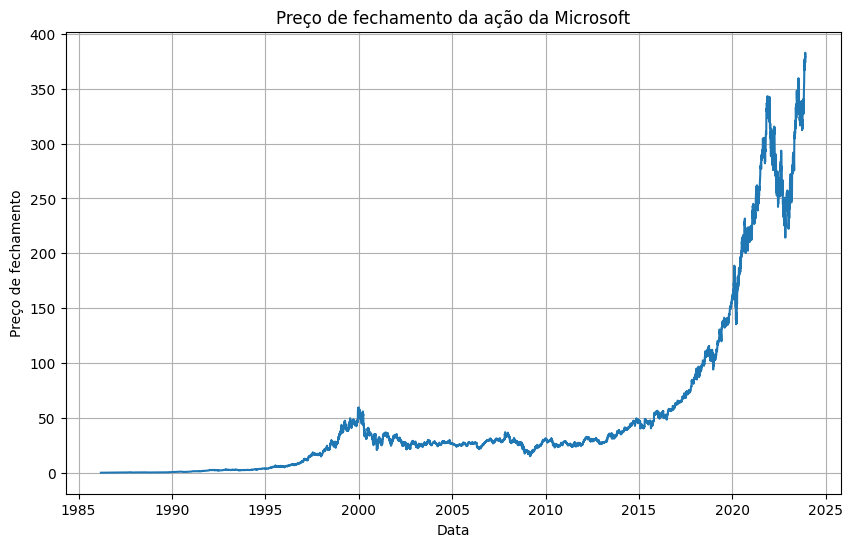

In [8]:
#Vamos plotar o gráfico
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('Data')
plt.ylabel('Preço de fechamento')
plt.plot(data)
plt.title('Preço de fechamento da ação da Microsoft')
plt.show()


In [9]:
#Precisamos converter isso em um problema de aprendizado de máquina supervisionado 

import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df



In [10]:
# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(data, 
                                '2021-03-25', 
                                '2023-11-28', 
                                n=3)

windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
670,2023-11-21,376.170013,369.850006,377.440002,373.070007
671,2023-11-22,369.850006,377.440002,373.070007,377.850006
672,2023-11-24,377.440002,373.070007,377.850006,377.429993
673,2023-11-27,373.070007,377.850006,377.429993,378.609985


In [11]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

In [12]:
dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((675,), (675, 3, 1), (675,))

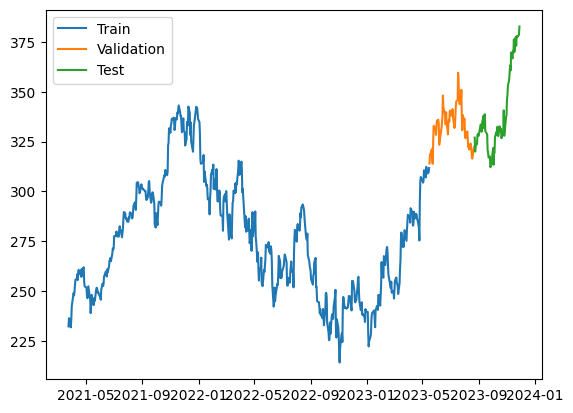

In [13]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000)

Epoch 1/1000
17/17 [==============================] - 7s 80ms/step - loss: 76123.9609 - mean_absolute_error: 274.3323 - val_loss: 108539.5391 - val_mean_absolute_error: 329.3036
Epoch 2/1000
17/17 [==============================] - 0s 9ms/step - loss: 74591.6484 - mean_absolute_error: 271.5378 - val_loss: 106408.8203 - val_mean_absolute_error: 326.0524
Epoch 3/1000
17/17 [==============================] - 0s 6ms/step - loss: 72356.3672 - mean_absolute_error: 267.3810 - val_loss: 102578.1875 - val_mean_absolute_error: 320.1241
Epoch 4/1000
17/17 [==============================] - 0s 4ms/step - loss: 68050.3984 - mean_absolute_error: 259.1865 - val_loss: 95543.1172 - val_mean_absolute_error: 308.9406
Epoch 5/1000
17/17 [==============================] - 0s 5ms/step - loss: 60603.4609 - mean_absolute_error: 244.3342 - val_loss: 83868.0703 - val_mean_absolute_error: 289.4293
Epoch 6/1000
17/17 [==============================] - 0s 8ms/step - loss: 49400.2812 - mean_absolute_error: 220.1222

17/17 [==============================] - 1s 2ms/step


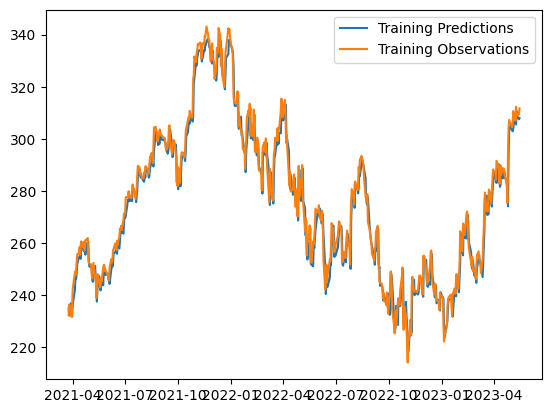

In [15]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

3/3 [==============================] - 0s 3ms/step


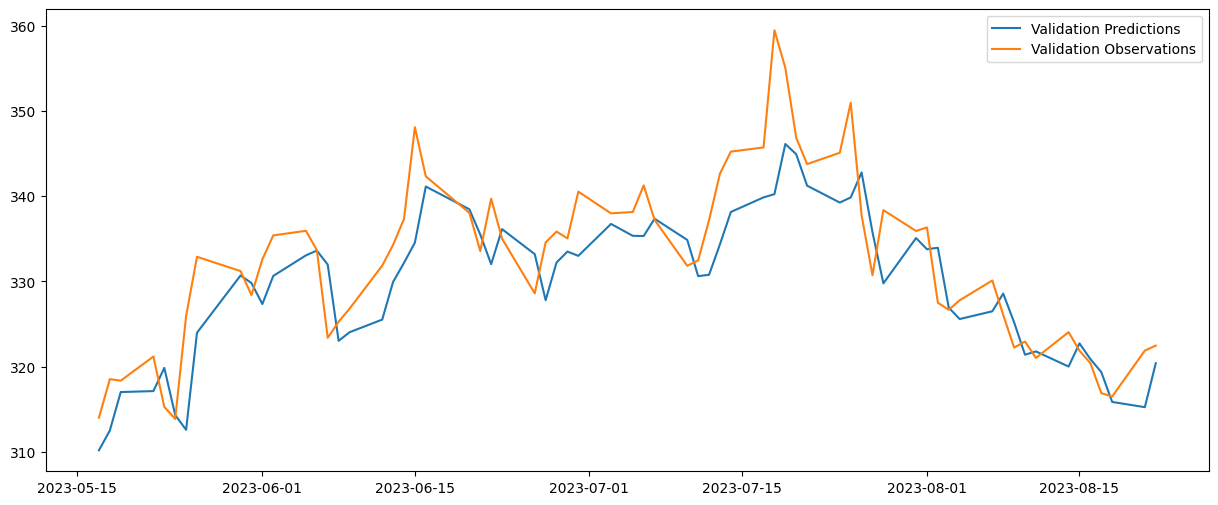

In [16]:
val_predictions = model.predict(X_val).flatten()
plt.figure(figsize=(15, 6))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

3/3 [==============================] - 0s 10ms/step


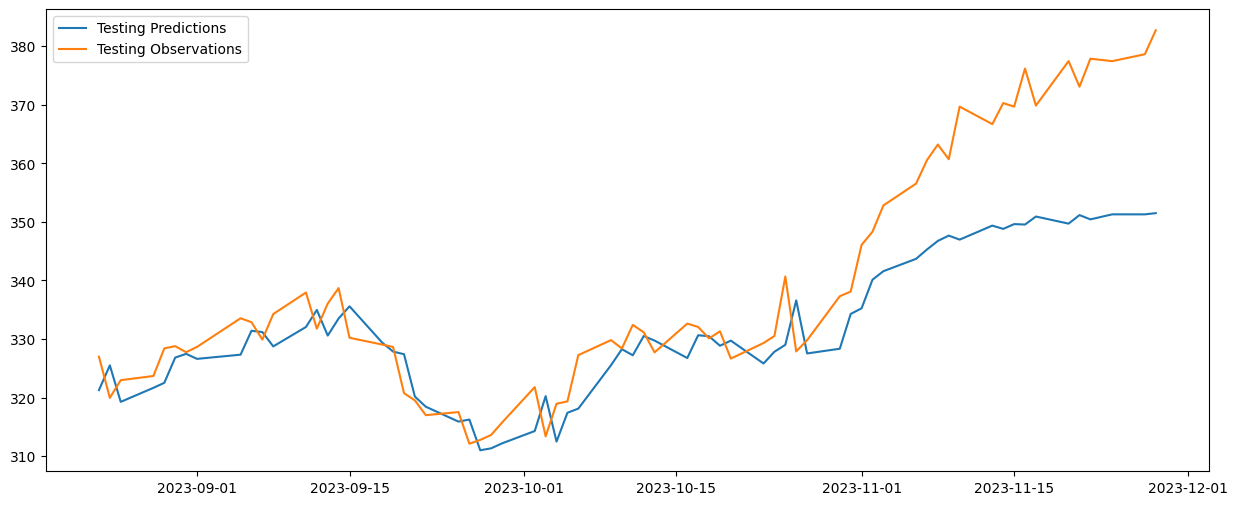

In [17]:
test_predictions = model.predict(X_test).flatten()
plt.figure(figsize=(15, 6))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

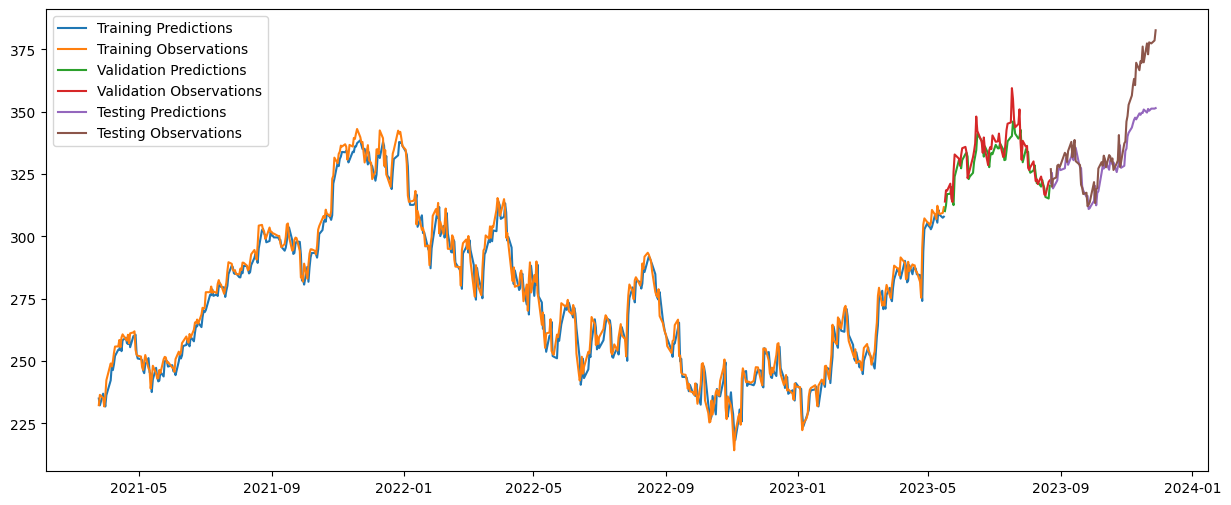

In [18]:
plt.figure(figsize=(15, 6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [19]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 28ms/step
